In [1083]:
import sys 
sys.path.append('../../')

In [1084]:
from sklearn.datasets._samples_generator import make_blobs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

X, y_true = make_blobs(n_samples=200, centers=4, n_features=3,
                       cluster_std=0.60, random_state=0,)

In [1085]:
def WireframeSphere(centre=[0.,0.,0.], radius=1.,
                    n_meridians=20, n_circles_latitude=None):
    """
    Create the arrays of values to plot the wireframe of a sphere.

    Parameters
    ----------
    centre: array like
        A point, defined as an iterable of three numerical values.
    radius: number
        The radius of the sphere.
    n_meridians: int
        The number of meridians to display (circles that pass on both poles).
    n_circles_latitude: int
        The number of horizontal circles (akin to the Equator) to display.
        Notice this includes one for each pole, and defaults to 4 or half
        of the *n_meridians* if the latter is larger.

    Returns
    -------
    sphere_x, sphere_y, sphere_z: arrays
        The arrays with the coordinates of the points to make the wireframe.
        Their shape is (n_meridians, n_circles_latitude).

    Examples
    --------
    >>> fig = plt.figure()
    >>> ax = fig.gca(projection='3d')
    >>> ax.set_aspect("equal")
    >>> sphere = ax.plot_wireframe(*WireframeSphere(), color="r", alpha=0.5)
    >>> fig.show()

    >>> fig = plt.figure()
    >>> ax = fig.gca(projection='3d')
    >>> ax.set_aspect("equal")
    >>> frame_xs, frame_ys, frame_zs = WireframeSphere()
    >>> sphere = ax.plot_wireframe(frame_xs, frame_ys, frame_zs, color="r", alpha=0.5)
    >>> fig.show()
    """
    if n_circles_latitude is None:
        n_circles_latitude = max(n_meridians/2, 4)
    u, v = np.mgrid[0:2*np.pi:n_meridians*1j, 0:np.pi:n_circles_latitude*1j]
    sphere_x = centre[0] + radius * np.cos(u) * np.sin(v)
    sphere_y = centre[1] + radius * np.sin(u) * np.sin(v)
    sphere_z = centre[2] + radius * np.cos(v)
    return sphere_x, sphere_y, sphere_z

In [1086]:
X_df = pd.DataFrame(X)
X_df.head()

,0,1,2
0,1.069239,4.530685,1.522596
1,-1.943908,7.783902,9.389831
2,2.142443,4.055616,1.606795
3,0.277118,-1.117947,2.435836
4,0.713425,3.552110,2.521762


In [1087]:
sns.set()

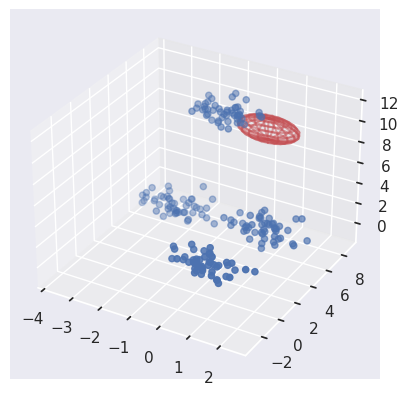

In [1088]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
sphere = ax.plot_wireframe(*WireframeSphere([1,5,11]), color="r", alpha=0.5)
ax.scatter(X_df[0], X_df[1], X_df[2])

plt.show()

### The algorithms
In comparison to 2D-Laplace there are three separate formulas to generate the PDF. These look a lot like the ones for 2D-Laplace, but use a shape 3 of the gamma distribution and include the azimuth angle.

In [1089]:
from scipy.stats import gamma

In [1090]:
radius = 0.5 # radius r
level = 2 #privacy level l
epsilon = level/radius
print(epsilon)

4.0


The azimuth ($\psi$) and theta ($\theta$) is generated using this paper: Generalised Differential Privacy for Text Document
Processing

In [1091]:
def generate_unit_sphere(): 
    vector = np.random.randn(3)
    vector /= np.linalg.norm(vector)

    #polar_angle = np.arccos(vector[2])
    #azimuth = np.arctan2(vector[1], vector[0])
    theta = 2 * np.random.uniform(0, np.pi)
    psi = np.arccos(2*np.random.uniform() - 1)
    return theta, psi, vector

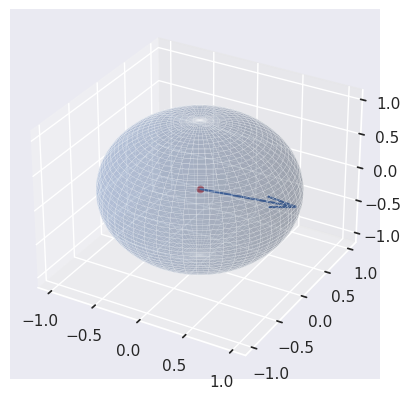

In [1092]:
polar_angle, azimuth, vector = generate_unit_sphere()
plt.figure()
ax = plt.subplot(111, projection='3d')
plot_unit_shere(ax, vector)

In [1093]:
from matplotlib.mlab import GaussianKDE
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm 
from scipy.interpolate import RBFInterpolator

def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = generate_unit_sphere() # theta, psi
    r = gamma.rvs(3, scale=1/epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    # https://mathworld.wolfram.com/SphericalCoordinates.html formula 4/5/6
    x = r * np.sin(polar_angle) * np.sin(azimuth)
    y = r * np.sin(polar_angle) * np.cos(azimuth)
    z = r * np.cos(polar_angle)
    return x, y, z

def euclidean_distance(p1, p2):
    return np.linalg.norm(p2 - p1)

def calculate_radius_with_noise(x0, n, epsilon): 
    """
        x0: Point to perturb
        n: amount of points to generate
        epsilon: privacy budget
    """
    Z = []
    total_dis = 0
    for nm in range(0, n):
        noise = generate_3D_noise(epsilon)
        z = x0 + noise;
        total_dis = total_dis + euclidean_distance(x0, z)
        Z.append(z)

    R = total_dis / n
    return np.array(Z), R

def display_noise(x0, epsilon, ax, amount_of_points = 10): 
    Z, R = calculate_radius_with_noise(x0, amount_of_points, epsilon)
    ax.plot_wireframe(*WireframeSphere(x0, radius=R*np.pi), color="r", alpha=0.2)
    
    return Z
def display_data_as_scatterplot(X, ax, s=1, c='b'): 
    X_prime = StandardScaler().fit_transform(X)
    #ax.scatter(x_0[0], x_0[1], x_0[2], c='r')
    ax.scatter(X_prime[:,0], X_prime[:,1], X_prime[:,2], c=c, s=s)
    return X_prime

def generate_3D_noise_for_dataset(X, epsilon):
    Z = []
    for x in X:
        noise = generate_3D_noise(epsilon)
        z = x + noise
        Z.append(z)
    return Z

def probabilityDensity(x, x0, eps):
    
    # Compute the Euclidean distance between x and x0
    #x, y, z = x0
    g = gamma(shape=3, scale=1/eps)
    n = norm()
    
    # Compute the function value at each x
    # return (eps**2 / (2 * np.pi)) * np.exp(-(eps * d))
    #return (1 / (4 * np.sqrt(np.pi))) * eps**3 * x**2 * np.exp(-(eps * x))
    return g.pdf(x[0, :]) * n.pdf(x[1, :]) * n.pdf(x[2, :])
def display_perturbed_data(Z, ax, x0 = None, epsilon = None):
    Z_prime = StandardScaler().fit_transform(Z)
    xyz = np.vstack([Z_prime[:,0], Z_prime[:,1], Z_prime[:,2]])
    kernel = GaussianKDE(xyz)(xyz)

    color = 'r' if x0 is None else kernel
    ax.scatter(Z_prime[:,0], Z_prime[:,1], Z_prime[:,2], c=color)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

def plot_row_with_epsilon_scores(X, epsilons, ax, row = 1): 
    i = 0
    for epsilon in epsilons:
        i += 1
        ax = fig.add_subplot(row, len(epsilons), i, projection='3d')
        ax.set_title('Epsilon ' + str(epsilon))
        display_data_as_scatterplot(X, ax)
        Z = generate_3D_noise_for_dataset(X, epsilon)
        display_perturbed_data(Z, ax)



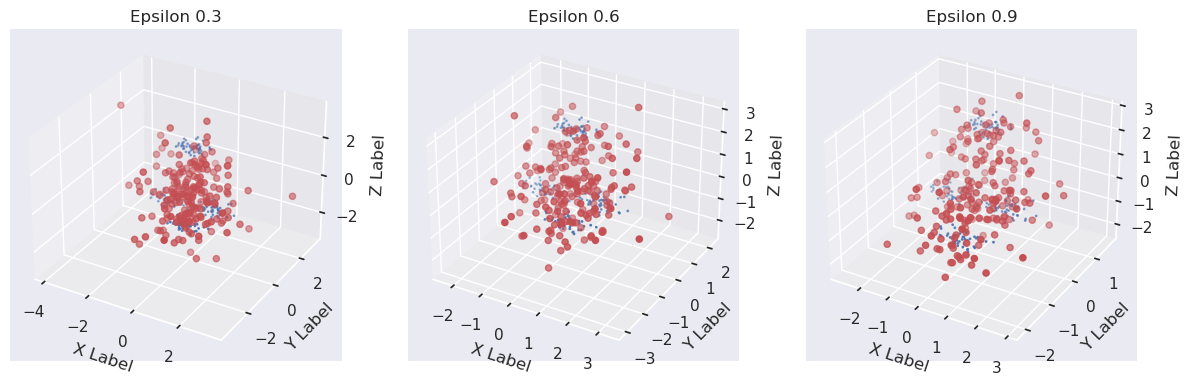

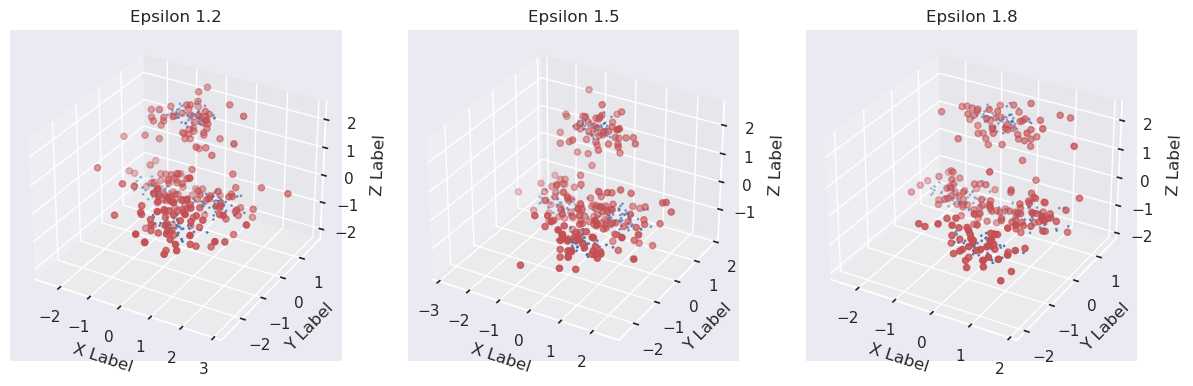

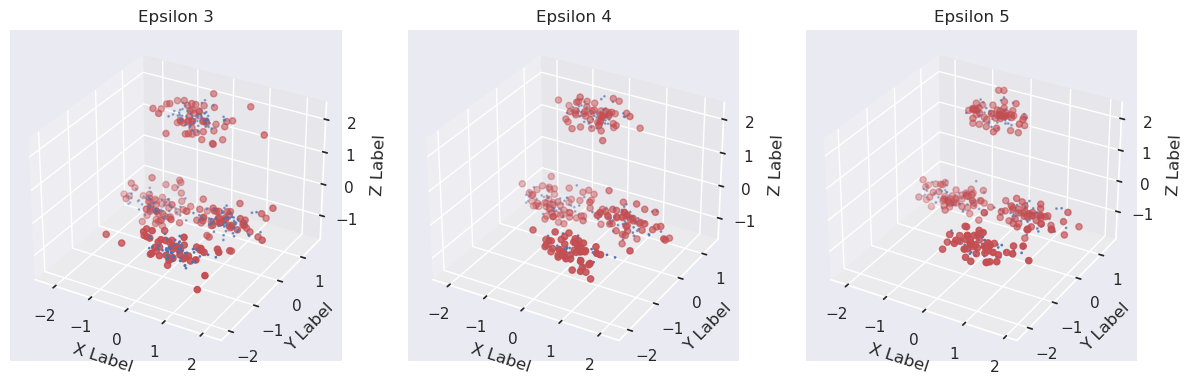

In [1094]:
radius = 0.5 # radius r
level = 2 #privacy level l
epsilon = level/radius
fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [0.3, 0.6, 0.9], fig)
plt.show()

fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [1.2, 1.5, 1.8], fig)

fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [3, 4, 5], fig)



In [1095]:
epsilons = [0.05, 0.1 , 0.5 , 1, 2, 3, 5, 7, 9]
for epsilon in epsilons:
    Z = generate_3D_noise_for_dataset(X, epsilon)
    Z_pd = pd.DataFrame(Z)
    Z_pd.to_csv('./export/perturbed_'+str(epsilon)+'.csv')

In [1096]:
X_pd = pd.DataFrame(X)
X_pd.to_csv('./export/plain.csv')

In [1097]:
x_0 = X[0]
x_0_scaled = StandardScaler().fit_transform(X)[0]
print(x_0_scaled, x_0)

[ 0.9639661   0.13017464 -0.6188006 ] [1.06923853 4.53068484 1.52259607]


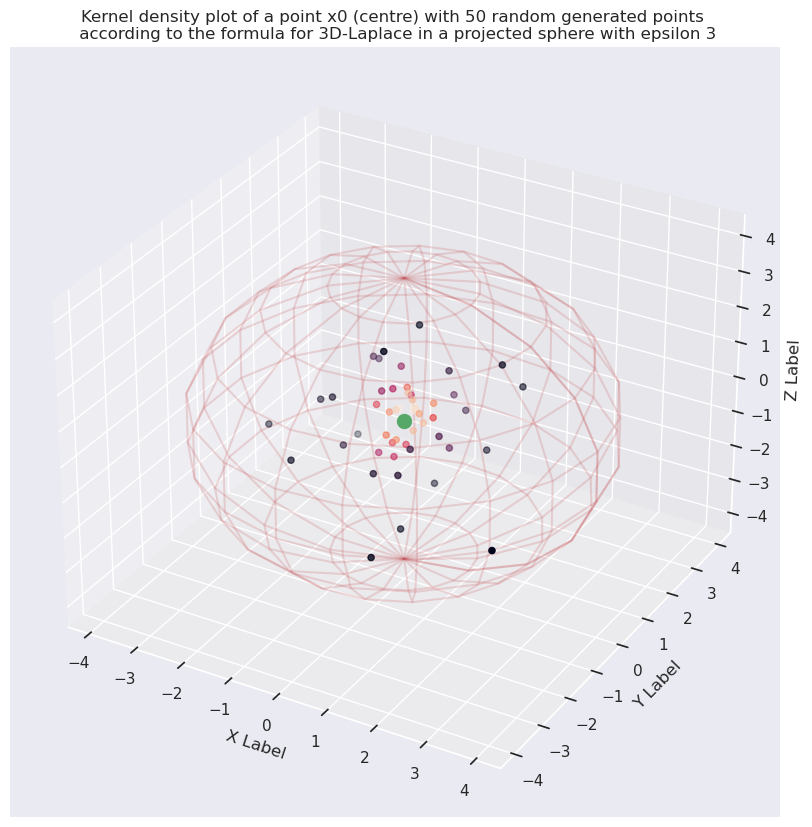

In [1103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
display_data_as_scatterplot([x_0_scaled], ax, s=100, c='g')
Z = []
for i in range(50):
    Z.append(generate_3D_noise_for_dataset([x_0], 5))

Z = np.array(Z)
Z = Z.reshape(-1, 3)
display_perturbed_data(Z, ax, x0 = x_0, epsilon = 3)
Z = np.absolute(StandardScaler().fit_transform(Z))
sphere = ax.plot_wireframe(*WireframeSphere(radius=4), color="r", alpha=0.2)
ax.set_title('Kernel density plot of a point x0 (centre) with 50 random generated points \n according to the formula for 3D-Laplace in a projected sphere with epsilon 3')
plt.show()
